# Wavenet by Keras
## Resources
- two popular implementations based on Keras so far
    - [keras-wavenet](https://github.com/usernaamee/keras-wavenet)
    - [wavenet](https://github.com/basveeling/wavenet)
- [Blog by deepmind](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)
- [Paper by deepmind](https://arxiv.org/pdf/1609.03499.pdf)

## Focus on [keras-wavenet](https://github.com/usernaamee/keras-wavenet) Implementation
- Data used: [Librispeech](http://www.openslr.org/12/)
- Resample and merge data into train and validation .wav files
```
cvlc -vvv --sout-keep --sout-all --sout "#gather:transcode{acodec=s16l,channels=1,samplerate=8000}:std{access=file,mux=wav,dst=validate.wav}" `find LibriSpeech/test-clean/ -name "*.flac"` vlc://quit
cvlc -vvv --sout-keep --sout-all --sout "#gather:transcode{acodec=s16l,channels=1,samplerate=8000}:std{access=file,mux=wav,dst=train.wav}" `find LibriSpeech/dev-clean/ -name "*.flac"` vlc://quit
```

In [1]:
%matplotlib inline

In [22]:
from scipy.io.wavfile import read, write
import numpy as np
from keras.callbacks import Callback
from keras.models import Model, Sequential
from keras.layers import Conv1D, AtrousConv1D, Flatten, Dense, Input
from keras.layers import Lambda, merge, Activation
from keras.utils import np_utils

import matplotlib.pyplot as plt

## read, process (normalize) wav files

In [3]:
!ls -lh ../data/librispeech/

total 548M
-rw-rw-r-- 1 1000 1000 274M Sep 19 13:13 train.wav
-rw-rw-r-- 1 1000 1000 275M Sep 19 13:13 validate.wav


a wave file is a numpy array with a sampling rate

(143256709,)


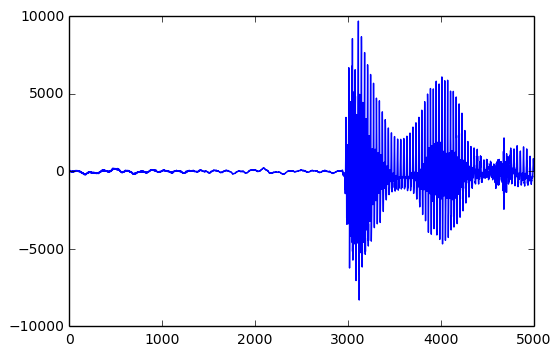

In [4]:
samplerate, audio = read("../data/librispeech/train.wav")
print audio.shape
plt.plot(audio[:5000])

In [5]:
def read_wav(wav_file):
    '''return wav as normalized numpy array in [-1. 1.]
    '''
    sampling_rate, audio = read(wav_file)
    audio = audio.astype(np.float)
    audio_min, audio_max = audio.min(), audio.max()
    audio = (audio - audio_min) * 1. / (audio_max - audio_min)
    audio = audio * 2 - 1
    return sampling_rate, audio

train_sr, train_audio = read_wav('../data/librispeech/train.wav')
test_sr, test_audio = read_wav('../data/librispeech/validate.wav')

assert train_sr == test_sr
print train_audio.shape, test_audio.shape

(143256709,) (143978215,)


## generate training examples
- sliding a window across the 1D signal
- target is encoded by [$\mu$-law algorithm](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm), to imporve snr
- the target is further encoded to 0 to 255 to make it a classification problem

In [28]:
nb_classes = 256
window = 2048
stride = 128

In [29]:
def mu_encode(signal, mu=nb_classes):
    sign = np.sign(signal)
    # -1 ~ 1
    encoded = sign * np.log(1+mu*np.abs(signal)) / np.log(1+mu) 
    # 0 ~ 255
    encoded = (encoded + 1) / 2 * mu
    return encoded.astype(np.int)

def mu_decode(signal, mu=nb_classes):
    # 0 - 1
    decoded = signal.astype(np.float) / mu
    # -1 to 1
    decoded = decoded * 2 - 1
    decoded = sign(decoded) * (1/mu) * ((1+u)**np.abs(signal) - 1)
    ## make it 16 bit
    decoded = decoded * 2**15
    return decoded

def data_generator(seq, window, stride, minibatch_size=32):
    i = 0
    ibatch = 0
    xs, ts = [], []
    while True:
        x = seq[i:i + window]
        t = seq[i + window + 1]
        xs.append(x)
        ts.append(t)
        i += stride
        if i >= len(seq):
            i = 0
        if len(xs) == minibatch_size:
            X = np.row_stack(xs)
            t = np.array(ts)
            t = mu_encode(t) # 0 ~ 256
            y = np_utils.to_categorical(t, nb_classes = nb_classes)
            yield X, y
            xs, ts = [], []

In [30]:
## test generator
g = data_generator(train_audio, window, stride)
for _ in xrange(10):
    X, y = g.next()
    assert X.shape == (32, 2048)
    assert y.shape == (32, nb_classes)
    assert np.all(0 <= y)
    assert np.all(y <= nb_classes)